In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

In [45]:
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-3/data'
RESULTS_PATH = '../results'
FIG_PATH = '../figs'
MODELS = ['ss', 'ss-sampler', 'ff']
MODELS_FIT = ['ss', 'ss-sampler', 'ff', 'null']
MODEL_LABELS = {
    'ss': 'Conj.',
    'ss-sampler': 'Conj.\nSampler',
    'ff': 'Feat.',
    'null': 'Null'
}
PARAM_LABELS = {
    'alpha': 'α',
    'beta': 'β',
    'segmentation': r'$\it{b}$',
}
#MODELS_FIT = ['ss', 'ss-sampler', 'ff']
COMPARISON_PARAMETERS = [
    'alpha',
    'beta',
    'beta_test',
    'segmentation',
    'sampler_feature_weight',
    'sampler_specificity'
]

# Model colors
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442',
    'null': 'grey'
}
MODEL_COLORS = {k: MODEL_COLORS[k] for k in MODELS_FIT}
MODEL_FIT_LABELS = {k: MODEL_LABELS[k] for k in MODELS_FIT}
MODEL_LABELS = {k: MODEL_LABELS[k] for k in MODELS}


# Functions

In [67]:
def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def sigmoid(x):
    """
    Sigmoid function

    Arguments
    ---------
    x : int or float
        input value

    Returns
    -------
    float
        sigmoid of x
    """
    return 1 / (1 + np.exp(-x))

def round_up(x, n):
    """
    Round up to n decimal places

    Arguments
    ---------
    x : int or float
        input value
    n : int
        number of decimal places
    
    Returns
    -------
    float
        x rounded up to n decimal
    """
    factor = 10**n
    return np.ceil(x*factor)/factor


def plot_parameter_relationship(
    df,
    x,
    y,
    x_label = None,
    y_label = None,
    color = None,
    fname = False
):
    """
    Plot relationship between two parameters

    Arguments
    ---------
    df : pandas.DataFrame
        data frame containing parameters
    x : str
        column name for x-axis
    y : str
        column name for y-axis
    x_label : str
        label for x-axis
    y_label : str
        label for y-axis
    color : str
        color for plot
    fname : str or bool
        file name to save plot, if False do not save
    
    Returns
    -------
    None
    """

    # Init JointGrid
    g = sns.JointGrid(data=df, x=x, y=y, height=1.75)

    # Plot Logistic
    sns.regplot(
        data = df,
        x = x,
        y = y,
        logistic = True,
        color = color,
        scatter_kws = {'s': 1},
        line_kws = {'color': 'black'},
        ax = g.ax_joint,
    )

    # Plot histograms on the marginal axes
    g.plot_marginals(
        sns.histplot,
        color = color
    )
    g.set_axis_labels(x_label, y_label)

    # Save figure if fname is provided
    if fname:
        plt.savefig(fname, bbox_inches='tight')

    # Print Pearson's and Spearman's correlations
    pear_val, pear_p = pearsonr(df[x], df[y])
    spear_val, spear_p = spearmanr(df[x], df[y])
    print(f"""
    {x} vs {y}
    Pearson's correlation: {np.round(pear_val, 2)} (p <= {round_up(pear_p, 4)})
    Spearman's correlation: {np.round(spear_val, 2)} (p <= {round_up(spear_p, 4)})
    """)


# Load Data
## Load Simulated Parameters

In [7]:
# Load simulated agent parameters
sim_params = []
for model in MODELS:
    for f in listdir(f'{DATA_PATH}/{model}/training'):
        if f.startswith('.'):
            continue
        agent_data = pd.read_csv(f'{DATA_PATH}/{model}/training/{f}')
        
        # Compute negative log likelihood of simulated choices
        agent_data['n_log_p'] = -np.log(agent_data['p'])
        agent_data = agent_data[[
            'id',
            'model_label',
            'n_log_p',
            *COMPARISON_PARAMETERS
        ]]
        agent_data = agent_data.groupby([
            'id',
            'model_label',
            *COMPARISON_PARAMETERS
        ])
        agent_data = agent_data.sum().reset_index()
        sim_params.append(agent_data.values[0])

# Combine into one data frame
sim_params = pd.DataFrame(
    sim_params,
    columns = ['id', 'model_label', *COMPARISON_PARAMETERS, 'nll']
)
sim_params

,id,model_label,alpha,beta,beta_test,segmentation,sampler_feature_weight,sampler_specificity,nll
0,1572,ss,0.718335,0.488733,0.488733,0.000000,1.0,1.0,78.642208
1,1214,ss,0.397096,0.162196,0.162196,0.000000,1.0,1.0,101.097449
2,1200,ss,0.528492,0.160937,0.160937,0.000000,1.0,1.0,98.145726
3,1566,ss,0.848066,0.000457,0.000457,0.000000,1.0,1.0,99.827315
4,1228,ss,0.989965,9.009203,9.009203,0.000000,1.0,1.0,18.507598
...,...,...,...,...,...,...,...,...,...
2995,420,ff,0.460257,2.162061,2.162061,0.480649,1.0,1.0,43.464357
2996,346,ff,0.176951,0.221070,0.221070,0.137609,1.0,1.0,99.287924
2997,408,ff,0.845294,0.819969,0.819969,0.979848,1.0,1.0,27.034556
2998,391,ff,0.590577,0.131829,0.131829,0.159932,1.0,1.0,94.262333


## Load Fitting Results

In [8]:
model_fits = []
for model in MODELS:
    this_model_fits = pd.read_csv(f'{RESULTS_PATH}/{model}/model_fits.csv')
    this_model_fits = this_model_fits[[
        'id',
        'model_label',
        'success',
        'nll', 
        'aic',
        *COMPARISON_PARAMETERS
    ]]
    model_fits.append(this_model_fits)
model_fits = pd.concat(model_fits)
model_fits = model_fits.reset_index(drop=True)
model_fits['model_label'] = model_fits['model_label'].replace(np.nan, 'null')
idx = np.isin(model_fits['model_label'], MODELS_FIT, invert=True)
model_fits = model_fits[~idx].reset_index(drop=True)
for param in COMPARISON_PARAMETERS:
    colname = f'{param}_fit_at_bound'
    model_fits[colname] = 'no'
    idx = model_fits[param] < np.min(model_fits[param]) + .01
    model_fits.loc[idx, colname] = 'lo'
    idx = model_fits[param] > np.max(model_fits[param]) - .01
    model_fits.loc[idx, colname] = 'hi'
model_fits

,id,model_label,success,nll,aic,alpha,beta,beta_test,segmentation,sampler_feature_weight,sampler_specificity,alpha_fit_at_bound,beta_fit_at_bound,beta_test_fit_at_bound,segmentation_fit_at_bound,sampler_feature_weight_fit_at_bound,sampler_specificity_fit_at_bound
0,1001,ff,True,298.830281,603.660562,0.000456,6484.338074,6484.338074,0.000100,1.000000,1.000000,no,no,no,no,hi,no
1,1001,null,True,299.439582,598.879164,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,lo,lo,lo,lo,lo,lo
2,1001,ss,True,294.988998,593.977996,0.999900,0.091815,0.091815,0.000000,1.000000,1.000000,hi,no,no,no,hi,no
3,1001,ss-sampler,True,298.667128,605.334256,0.035009,16.301060,16.301060,0.000000,0.200000,1.000000,no,no,no,no,no,no
4,1002,ff,True,298.006773,602.013546,0.000258,16570.013325,16570.013325,0.000100,1.000000,1.000000,no,no,no,no,hi,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,999,ss-sampler,True,192.539557,393.079114,0.999900,0.522287,0.522287,0.000000,1.000000,5.953928,hi,no,no,no,hi,no
11996,1000,ff,True,299.439222,604.878443,0.000413,2.877803,2.877803,0.345472,1.000000,1.000000,no,no,no,no,hi,no
11997,1000,null,True,299.439582,598.879164,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,lo,lo,lo,lo,lo,lo
11998,1000,ss,True,299.318866,602.637732,0.999900,0.020316,0.020316,0.000000,1.000000,1.000000,hi,no,no,no,hi,no


## Combine into one data frame

In [9]:
# Marge simulated and fit parameters
model_fits = pd.merge(
    sim_params,
    model_fits,
    on = 'id',
    suffixes = ('_sim', '_fit')
)

# Transform betas to be bounded [0, 1]
for param in COMPARISON_PARAMETERS:
    if ('beta' in param) or (param == 'sampler_specificity'):
        model_fits[f'{param}_trans_sim'] = sigmoid(model_fits[f'{param}_sim'])
        model_fits[f'{param}_trans_fit'] = sigmoid(model_fits[f'{param}_fit'])

model_fits

,id,model_label_sim,alpha_sim,beta_sim,beta_test_sim,segmentation_sim,sampler_feature_weight_sim,sampler_specificity_sim,nll_sim,model_label_fit,...,beta_test_fit_at_bound,segmentation_fit_at_bound,sampler_feature_weight_fit_at_bound,sampler_specificity_fit_at_bound,beta_trans_sim,beta_trans_fit,beta_test_trans_sim,beta_test_trans_fit,sampler_specificity_trans_sim,sampler_specificity_trans_fit
0,1572,ss,0.718335,0.488733,0.488733,0.000000,1.0,1.0,78.642208,ff,...,no,hi,hi,no,0.619808,0.509194,0.619808,0.509194,0.731059,0.731059
1,1572,ss,0.718335,0.488733,0.488733,0.000000,1.0,1.0,78.642208,null,...,lo,lo,lo,lo,0.619808,0.268941,0.619808,0.268941,0.731059,0.268941
2,1572,ss,0.718335,0.488733,0.488733,0.000000,1.0,1.0,78.642208,ss,...,no,no,hi,no,0.619808,0.717617,0.619808,0.717617,0.731059,0.731059
3,1572,ss,0.718335,0.488733,0.488733,0.000000,1.0,1.0,78.642208,ss-sampler,...,no,no,no,no,0.619808,1.000000,0.619808,1.000000,0.731059,0.975954
4,1214,ss,0.397096,0.162196,0.162196,0.000000,1.0,1.0,101.097449,ff,...,no,no,hi,no,0.540460,0.738312,0.540460,0.738312,0.731059,0.731059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,391,ff,0.590577,0.131829,0.131829,0.159932,1.0,1.0,94.262333,ss-sampler,...,no,no,hi,no,0.532909,0.528921,0.532909,0.528921,0.731059,1.000000
11996,385,ff,0.293165,0.067843,0.067843,0.187319,1.0,1.0,97.004490,ff,...,no,no,hi,no,0.516954,0.522981,0.516954,0.522981,0.731059,0.731059
11997,385,ff,0.293165,0.067843,0.067843,0.187319,1.0,1.0,97.004490,null,...,lo,lo,lo,lo,0.516954,0.268941,0.516954,0.268941,0.731059,0.268941
11998,385,ff,0.293165,0.067843,0.067843,0.187319,1.0,1.0,97.004490,ss,...,no,no,hi,no,0.516954,0.535748,0.516954,0.535748,0.731059,0.731059


# Model Recovery

## Compute if the best fitting model matches the simulated model

In [10]:
model_comparison = model_fits[[
    'id',
    'model_label_sim',
    'model_label_fit',
    'aic'
]]

# Compute the minimum AIC for each agent
min_aic = model_comparison[['id', 'aic']].groupby('id').min()
min_aic = min_aic.reset_index()
model_comparison = pd.merge(
    model_comparison,
    min_aic,
    on = 'id',
    suffixes = ('', '_min')
)

# Identify the model with the lowest AIC
model_comparison['best_fit'] = (
    model_comparison['aic'] == model_comparison['aic_min']
).astype(int)

# Get best fitting models only
best_fits = model_comparison[model_comparison['best_fit'] == 1]
best_fits = best_fits.reset_index(drop=True) 

# Model is recovered if the best fit model matches the simulated model
best_fits['recovered'] = (
    (best_fits['model_label_sim'] == best_fits['model_label_fit']) &
    (best_fits['best_fit'] == 1)
).astype(int)

best_fits

,id,model_label_sim,model_label_fit,aic,aic_min,best_fit,recovered
0,1572,ss,ss,536.499231,536.499231,1,1
1,1214,ss,null,598.879164,598.879164,1,0
2,1200,ss,ss,593.803202,593.803202,1,1
3,1566,ss,null,598.879164,598.879164,1,0
4,1228,ss,ss,321.771462,321.771462,1,1
...,...,...,...,...,...,...,...
2995,420,ff,ff,227.454212,227.454212,1,1
2996,346,ff,null,598.879164,598.879164,1,0
2997,408,ff,ff,253.273379,253.273379,1,1
2998,391,ff,ff,563.308105,563.308105,1,1


## Plot model recovery rates

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/1500827767.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_LABELS.values())


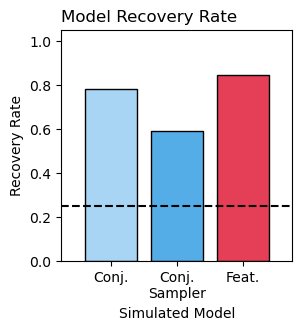

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = best_fits,
    x = 'model_label_sim',
    y = 'recovered',
    order = MODELS,
    ci = None,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.axhline(1/len(MODELS_FIT), color='black', linestyle='--')
ax.set_xlabel('Simulated Model')
ax.set_ylabel('Recovery Rate')
ax.set_xlim(-0.75, 2.75)
ax.set_ylim(0, 1.05)
ax.set_title('Model Recovery Rate', loc='left')
ax.set_xticklabels(MODEL_LABELS.values())
set_axis_ratio(ax)

## Fit rates for each model

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/2204730384.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_LABELS.values())
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/2204730384.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0, .2, .4, .6, .8, 1])


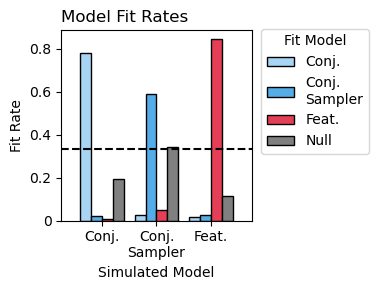

In [43]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(
    data = best_fits,
    x = 'model_label_sim',
    order = MODELS,
    hue = 'model_label_fit',
    hue_order = MODELS_FIT,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.axhline((len(best_fits)/3)/len(MODELS), color='black', linestyle='--')
ax.legend(MODEL_FIT_LABELS.values(), title='Fit Model', loc=(1.05, .35))
ax.set_xlabel('Simulated Model')
ax.set_ylabel('Fit Rate')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Model Fit Rates', loc='left')
ax.set_xticklabels(MODEL_LABELS.values())
ax.set_yticklabels([0, .2, .4, .6, .8, 1])
set_axis_ratio(ax)
fig.tight_layout()
fig.savefig(f'{FIG_PATH}/model-fit-rates.pdf')

## Fit rates for each model by aggregated AIC

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/2347612413.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_LABELS.values())


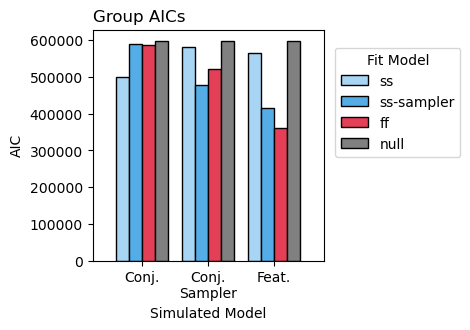

In [24]:
aic_comparison = model_comparison[['model_label_sim', 'model_label_fit', 'aic']]
aic_comparison = aic_comparison.groupby(['model_label_sim', 'model_label_fit'])
aic_comparison = aic_comparison.sum()
aic_comparison = aic_comparison.reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = aic_comparison,
    x = 'model_label_sim',
    y = 'aic',
    order = MODELS,
    hue = 'model_label_fit',
    hue_order = MODELS_FIT,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.legend(title='Fit Model', loc=(1.05, .45))
ax.set_xlabel('Simulated Model')
ax.set_ylabel('AIC')
ax.set_xlim(-0.75, 2.75)
ax.set_title('Group AICs', loc='left')
ax.set_xticklabels(MODEL_LABELS.values())
set_axis_ratio(ax)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/275781403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/275781403.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_FIT_LABELS.values())


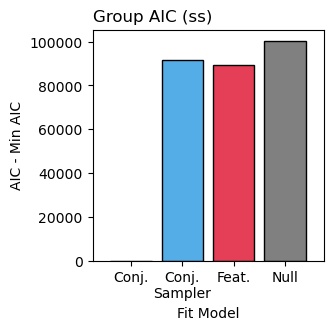

In [17]:
idx = aic_comparison['model_label_sim'] == 'ss'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS_FIT,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, len(MODELS_FIT) - 1 + .75)
ax.set_title('Group AIC (ss)', loc='left')
ax.set_xticklabels(MODEL_FIT_LABELS.values())
set_axis_ratio(ax)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/2003529764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/2003529764.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_FIT_LABELS.values())


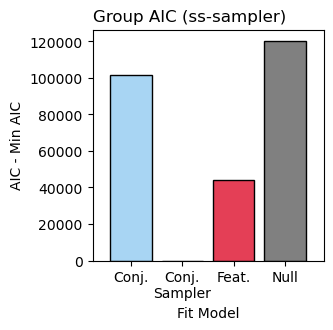

In [25]:
idx = aic_comparison['model_label_sim'] == 'ss-sampler'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS_FIT,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, len(MODELS_FIT) - 1 + .75)
ax.set_title('Group AIC (ss-sampler)', loc='left')
ax.set_xticklabels(MODEL_FIT_LABELS.values())
set_axis_ratio(ax)

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/1841526148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ff_aic_comparison['aic_diff'] = (
/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_97034/1841526148.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(MODEL_FIT_LABELS.values())


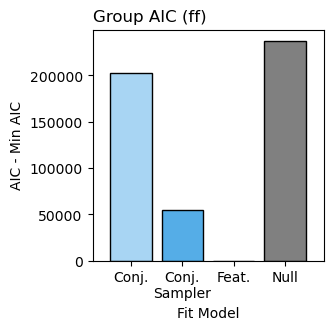

In [26]:
idx = aic_comparison['model_label_sim'] == 'ff'
ff_aic_comparison = aic_comparison[idx]

# Compute difference in AIC from the best fitting model
ff_aic_comparison['aic_diff'] = (
    ff_aic_comparison['aic'] - ff_aic_comparison['aic'].min()
)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data = ff_aic_comparison,
    x = 'model_label_fit',
    y = 'aic_diff',
    order = MODELS_FIT,
    palette = MODEL_COLORS,
    edgecolor = 'black'
)
ax.set_xlabel('Fit Model')
ax.set_ylabel('AIC - Min AIC')
ax.set_xlim(-0.75, len(MODELS_FIT) - 1 + .75)
ax.set_title('Group AIC (ff)', loc='left')
ax.set_xticklabels(MODEL_FIT_LABELS.values())
set_axis_ratio(ax)

# Parameter Recovery

## Conjunctive Model

### Learning Rate Recovery


    alpha_sim vs alpha_fit
    Pearson's correlation: 0.5 (p <= 0.0001)
    Spearman's correlation: 0.52 (p <= 0.0001)
    

    alpha_sim vs beta_trans_fit
    Pearson's correlation: 0.05 (p <= 0.1121)
    Spearman's correlation: 0.03 (p <= 0.3373)
    

    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.33 (p <= 0.0001)
    Spearman's correlation: -0.3 (p <= 0.0001)
    


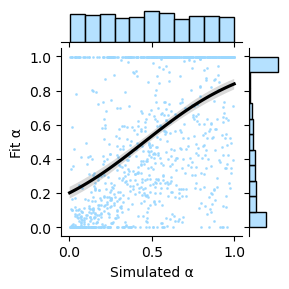

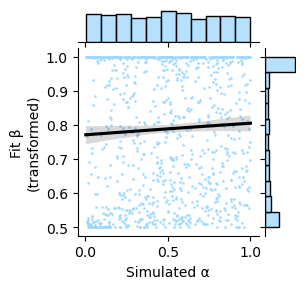

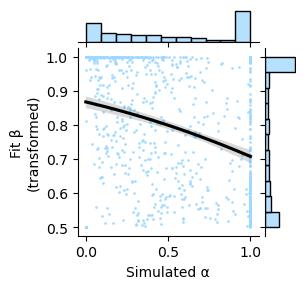

In [ ]:
idx = (
    (model_fits['model_label_sim'] == 'ss') &
    (model_fits['model_label_fit'] == 'ss')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = f'Fit {PARAM_LABELS["alpha"]}',
    color = MODEL_COLORS['ss']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = f'Fit {PARAM_LABELS["beta"]}\n(transformed)',
    color = MODEL_COLORS['ss']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = f'Fit {PARAM_LABELS["beta"]}\n(transformed)',
    color = MODEL_COLORS['ss']
)

### Inverse Temperature Recovery


    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.65 (p <= 0.0001)
    Spearman's correlation: 0.61 (p <= 0.0001)
    


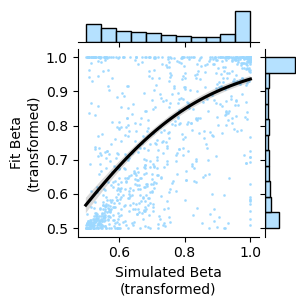

In [93]:
idx = (
    (model_fits['model_label_sim'] == 'ss') &
    (model_fits['model_label_fit'] == 'ss')
)
plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss']
)

## Conjunctive Sampler Model

### Learning Rate Recovery


    alpha_sim vs alpha_fit
    Pearson's correlation: 0.21 (p <= 0.0001)
    Spearman's correlation: 0.22 (p <= 0.0001)
    

    alpha_sim vs beta_trans_fit
    Pearson's correlation: 0.0 (p <= 0.9468)
    Spearman's correlation: -0.1 (p <= 0.0023)
    

    alpha_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.06 (p <= 0.077)
    Spearman's correlation: 0.05 (p <= 0.0856)
    

    alpha_sim vs sampler_specificity_trans_fit
    Pearson's correlation: 0.01 (p <= 0.748)
    Spearman's correlation: -0.06 (p <= 0.0762)
    

    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.5 (p <= 0.0001)
    Spearman's correlation: -0.56 (p <= 0.0001)
    

    alpha_fit vs sampler_feature_weight_fit
    Pearson's correlation: -0.09 (p <= 0.0064)
    Spearman's correlation: -0.07 (p <= 0.0198)
    

    alpha_fit vs sampler_specificity_trans_fit
    Pearson's correlation: -0.08 (p <= 0.008)
    Spearman's correlation: -0.11 (p <= 0.0003)
    


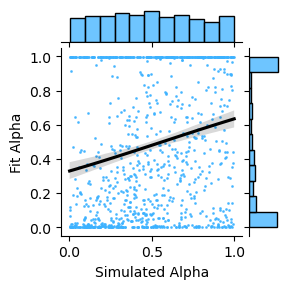

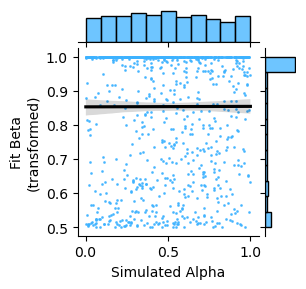

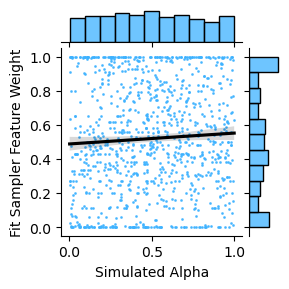

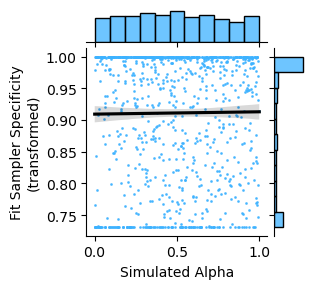

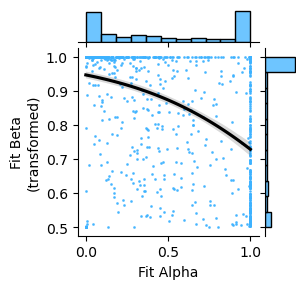

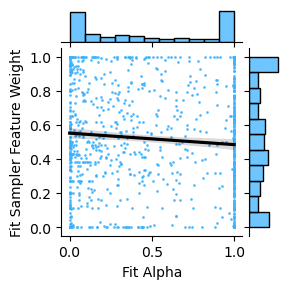

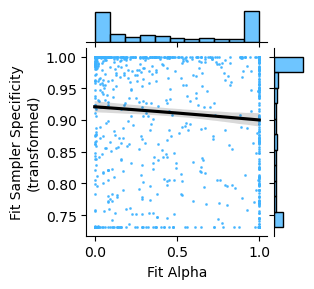

In [94]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Alpha',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Alpha',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'sampler_feature_weight_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Alpha',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Inverse Temperature Recovery


    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.34 (p <= 0.0001)
    Spearman's correlation: 0.22 (p <= 0.0001)
    

    beta_trans_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.06 (p <= 0.0682)
    Spearman's correlation: 0.06 (p <= 0.0466)
    

    beta_trans_sim vs sampler_specificity_trans_fit
    Pearson's correlation: -0.14 (p <= 0.0001)
    Spearman's correlation: -0.21 (p <= 0.0001)
    

    beta_trans_fit vs sampler_feature_weight_fit
    Pearson's correlation: -0.09 (p <= 0.0027)
    Spearman's correlation: -0.1 (p <= 0.0019)
    

    beta_trans_fit vs sampler_specificity_trans_fit
    Pearson's correlation: -0.05 (p <= 0.0855)
    Spearman's correlation: -0.03 (p <= 0.3572)
    


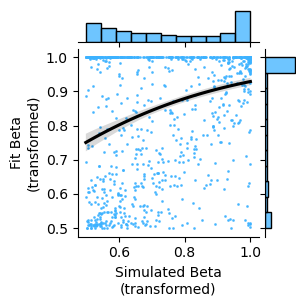

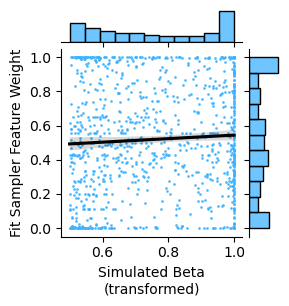

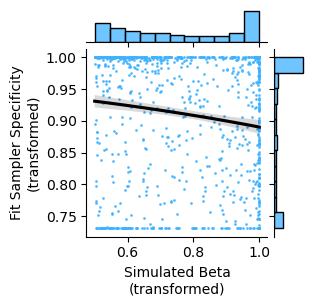

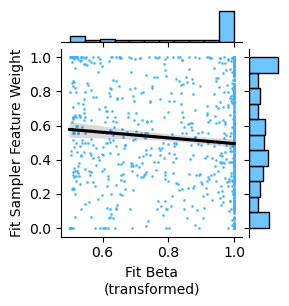

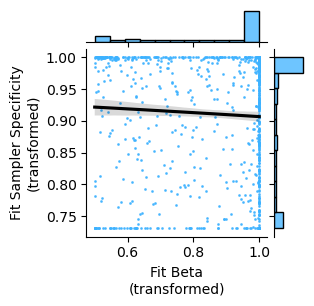

In [95]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'sampler_feature_weight_fit',
    x_label = 'Fit Beta\n(transformed)',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Beta\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Sampler Feature Weight


    sampler_feature_weight_sim vs sampler_feature_weight_fit
    Pearson's correlation: 0.58 (p <= 0.0001)
    Spearman's correlation: 0.58 (p <= 0.0001)
    

    sampler_feature_weight_sim vs sampler_specificity_trans_fit
    Pearson's correlation: -0.07 (p <= 0.031)
    Spearman's correlation: -0.05 (p <= 0.0958)
    

    sampler_feature_weight_fit vs sampler_specificity_trans_fit
    Pearson's correlation: -0.02 (p <= 0.5178)
    Spearman's correlation: 0.04 (p <= 0.2334)
    


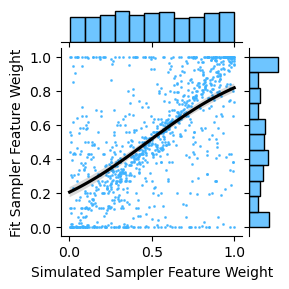

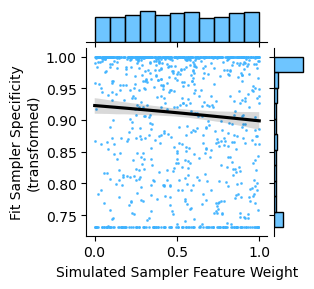

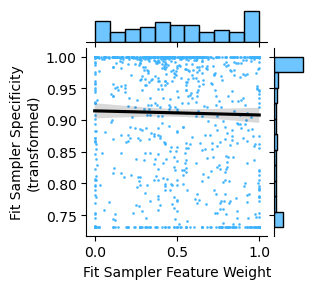

In [98]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_sim',
    'sampler_feature_weight_fit',
    x_label = 'Simulated Sampler Feature Weight',
    y_label = 'Fit Sampler Feature Weight',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Sampler Feature Weight',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_feature_weight_fit',
    'sampler_specificity_trans_fit',
    x_label = 'Fit Sampler Feature Weight',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

### Sampler Specificity


    sampler_specificity_trans_sim vs sampler_specificity_trans_fit
    Pearson's correlation: 0.44 (p <= 0.0001)
    Spearman's correlation: 0.39 (p <= 0.0001)
    


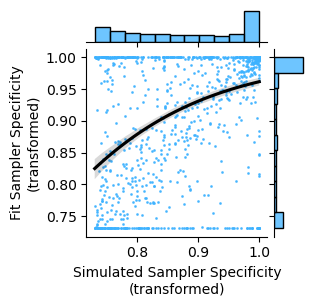

In [99]:
idx = (
    (model_fits['model_label_sim'] == 'ss-sampler') &
    (model_fits['model_label_fit'] == 'ss-sampler')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'sampler_specificity_trans_sim',
    'sampler_specificity_trans_fit',
    x_label = 'Simulated Sampler Specificity\n(transformed)',
    y_label = 'Fit Sampler Specificity\n(transformed)',
    color = MODEL_COLORS['ss-sampler']
)

## Feature-Based Model

### Learning Rate Recovery

/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    alpha_sim vs alpha_fit
    Pearson's correlation: 0.56 (p <= 0.0001)
    Spearman's correlation: 0.55 (p <= 0.0001)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    alpha_sim vs beta_trans_fit
    Pearson's correlation: -0.0 (p <= 0.9109)
    Spearman's correlation: -0.02 (p <= 0.5781)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    alpha_sim vs segmentation_fit
    Pearson's correlation: 0.05 (p <= 0.1242)
    Spearman's correlation: 0.05 (p <= 0.1356)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    alpha_fit vs beta_trans_fit
    Pearson's correlation: -0.43 (p <= 0.0001)
    Spearman's correlation: -0.46 (p <= 0.0001)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    alpha_fit vs segmentation_fit
    Pearson's correlation: 0.04 (p <= 0.197)
    Spearman's correlation: 0.05 (p <= 0.0833)
    


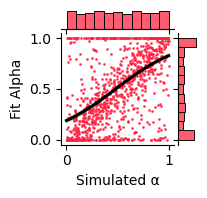

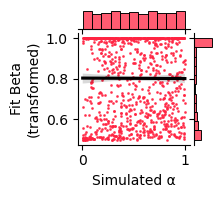

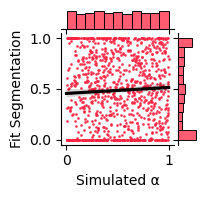

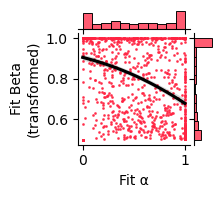

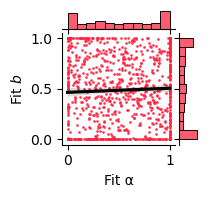

In [71]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'alpha_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = 'Fit Alpha',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'beta_trans_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_sim',
    'segmentation_fit',
    x_label = f'Simulated {PARAM_LABELS["alpha"]}',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'beta_trans_fit',
    x_label = f'Fit {PARAM_LABELS["alpha"]}',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'alpha_fit',
    'segmentation_fit',
    x_label = f'Fit {PARAM_LABELS["alpha"]}\n',
    y_label = f'Fit {PARAM_LABELS["segmentation"]}',
    color = MODEL_COLORS['ff'],
    fname = f'{FIG_PATH}/ff-alpha-fit-vs-bias-fit.pdf'
)


### Inverse Temperature Recovery

/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    beta_trans_sim vs beta_trans_fit
    Pearson's correlation: 0.61 (p <= 0.0001)
    Spearman's correlation: 0.54 (p <= 0.0001)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    beta_trans_sim vs segmentation_fit
    Pearson's correlation: 0.11 (p <= 0.0009)
    Spearman's correlation: 0.1 (p <= 0.0012)
    


/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    beta_trans_fit vs segmentation_fit
    Pearson's correlation: 0.08 (p <= 0.0103)
    Spearman's correlation: 0.09 (p <= 0.0028)
    


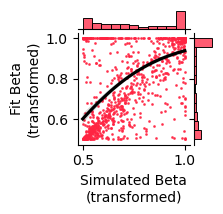

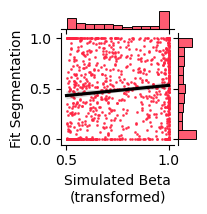

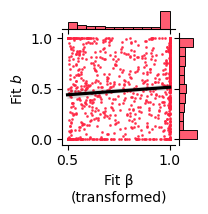

In [70]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'beta_trans_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Beta\n(transformed)',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_sim',
    'segmentation_fit',
    x_label = 'Simulated Beta\n(transformed)',
    y_label = 'Fit Segmentation',
    color = MODEL_COLORS['ff']
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'beta_trans_fit',
    'segmentation_fit',
    x_label = f'Fit {PARAM_LABELS["beta"]}\n(transformed)',
    y_label = f'Fit {PARAM_LABELS["segmentation"]}',
    color = MODEL_COLORS['ff'],
    fname = f'{FIG_PATH}/ff-beta-fit-vs-bias-fit.pdf'
)


### Segmentation Recovery

/Users/euanprentis/opt/anaconda3/envs/bambi/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()



    segmentation_sim vs segmentation_fit
    Pearson's correlation: 0.68 (p <= 0.0001)
    Spearman's correlation: 0.66 (p <= 0.0001)
    


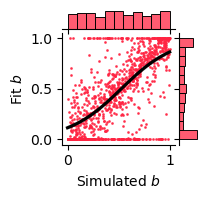

In [72]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

plot_parameter_relationship(
    model_fits.loc[idx],
    'segmentation_sim',
    'segmentation_fit',
    x_label = f'Simulated {PARAM_LABELS["segmentation"]}\n',
    y_label = f'Fit {PARAM_LABELS["segmentation"]}',
    color = MODEL_COLORS['ff'],
    fname = f'{FIG_PATH}/ff-bias-sim-vs-bias-fit.pdf'
)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/4087428086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['alpha_at_lo_bound'] = plot_df['alpha_fit'] == np.min(plot_df['alpha_fit'])


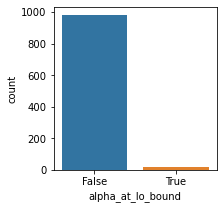

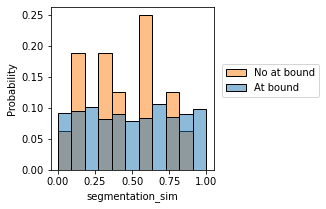

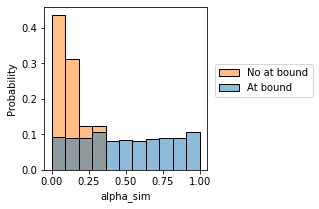

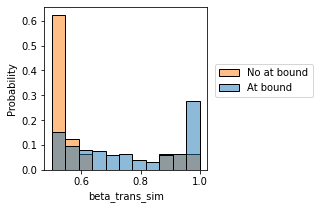

In [141]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['alpha_at_lo_bound'] = plot_df['alpha_fit'] == np.min(plot_df['alpha_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'alpha_at_lo_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'alpha_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/1748582661.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['alpha_at_hi_bound'] = plot_df['alpha_fit'] == np.max(plot_df['alpha_fit'])


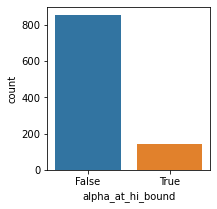

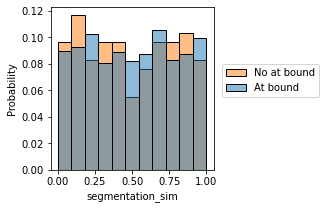

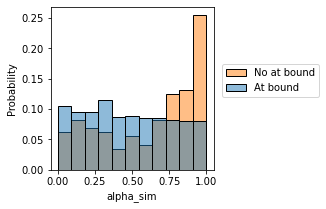

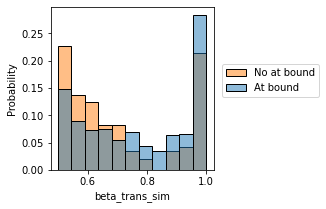

In [140]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['alpha_at_hi_bound'] = plot_df['alpha_fit'] == np.max(plot_df['alpha_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'alpha_at_hi_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'alpha_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/855376355.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_at_lo_bound'] = plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit'])


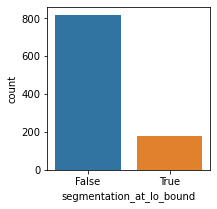

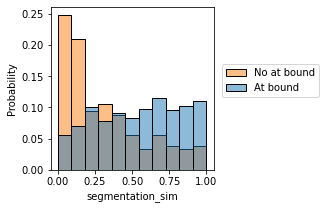

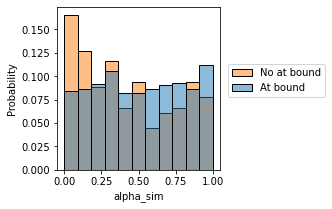

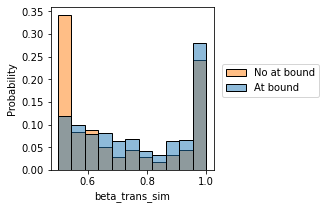

In [142]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['segmentation_at_lo_bound'] = plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'segmentation_at_lo_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'segmentation_at_lo_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_16225/475082918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_at_hi_bound'] = plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])


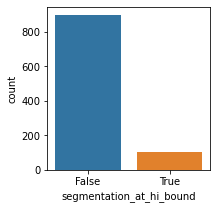

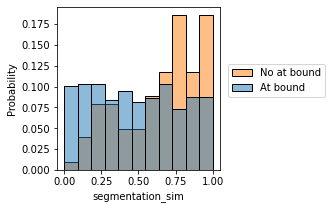

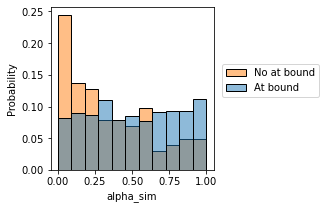

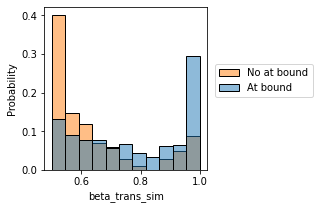

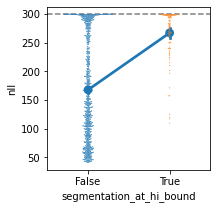

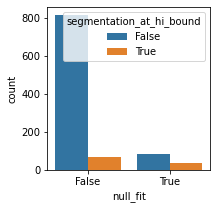

In [163]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
plot_df = model_fits.loc[idx]
plot_df['segmentation_at_hi_bound'] = plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])

fig, ax = plt.subplots(figsize=(3, 3))
sns.countplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    ax = ax
)
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'segmentation_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'alpha_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = plot_df,
    x = 'beta_trans_sim',
    hue = 'segmentation_at_hi_bound',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
ax.legend(['No at bound', 'At bound'], loc=(1.05, .45))
set_axis_ratio(ax)

fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(plot_df['null_nll'].values[0], color='grey', linestyle='--', zorder=0)
sns.swarmplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    y = 'nll',
    s = 1,
    ax = ax
)
sns.pointplot(
    data = plot_df,
    x = 'segmentation_at_hi_bound',
    y = 'nll',
    ax = ax
)
set_axis_ratio(ax)

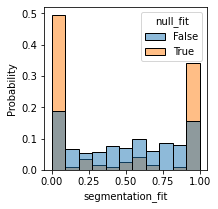

In [167]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(
    data = model_fits.loc[idx],
    x = 'segmentation_fit',
    hue = 'null_fit',
    stat = 'probability',
    common_norm = False,
    ax = ax
)
set_axis_ratio(ax)

In [175]:
plot_df = model_fits.loc[idx, ['null_fit', 'segmentation_fit']]
plot_df['segmentation_at_bound'] = (
    (plot_df['segmentation_fit'] == np.max(plot_df['segmentation_fit'])) | 
    (plot_df['segmentation_fit'] == np.min(plot_df['segmentation_fit']))
)

both = np.sum(plot_df['null_fit'] & plot_df['segmentation_at_bound'])
both/np.sum(plot_df['segmentation_at_bound'])

0.3215547703180212

<AxesSubplot:xlabel='nll_sim', ylabel='nll_fit'>

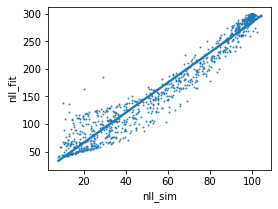

In [221]:
idx = (
    (model_fits['model_label_sim'] == 'ff') &
    (model_fits['model_label_fit'] == 'ff')
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.regplot(
    data = model_fits.loc[idx],
    x = 'nll_sim',
    y = 'nll_fit',
    scatter_kws = {'s': 1},
    ax = ax
)

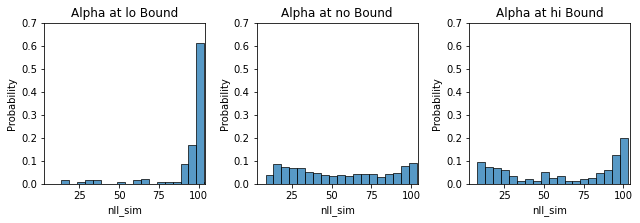

In [263]:


fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, bound_level in enumerate(['lo', 'no', 'hi']):
    ax = axs[i]
    idx = (
        (model_fits['model_label_sim'] == 'ff') &
        (model_fits['model_label_fit'] == 'ff') &
        (model_fits['alpha_fit_at_bound'] == bound_level) 
    )
    sns.histplot(
        data = model_fits.loc[idx],
        x = 'nll_sim',
        stat = 'probability',
        common_norm = False,
        binwidth = 5,
        ax = ax
    )
    ax.set_xlim(np.min(model_fits['nll_sim']), np.max(model_fits['nll_sim']))
    ax.set_ylim(0, .7)
    ax.set_title(f'Alpha at {bound_level} Bound')
    set_axis_ratio(ax)
fig.tight_layout()

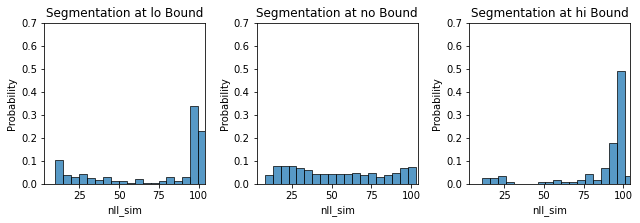

In [265]:


fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, bound_level in enumerate(['lo', 'no', 'hi']):
    ax = axs[i]
    idx = (
        (model_fits['model_label_sim'] == 'ff') &
        (model_fits['model_label_fit'] == 'ff') &
        (model_fits['segmentation_fit_at_bound'] == bound_level) 
    )
    sns.histplot(
        data = model_fits.loc[idx],
        x = 'nll_sim',
        stat = 'probability',
        common_norm = False,
        binwidth = 5,
        ax = ax
    )
    ax.set_xlim(np.min(model_fits['nll_sim']), np.max(model_fits['nll_sim']))
    ax.set_ylim(0, .7)
    ax.set_title(f'Segmentation at {bound_level} Bound')
    set_axis_ratio(ax)
fig.tight_layout()

In [270]:
np.sum([-np.log(.6)]*(72 + 144))

110.33833473345396